## 1 Introduction

In Sane et al.’s paper (2023), the author’s describe how when they split the data into two sets, and trained a neural network on each set, they saw an improvement in performance. We aimed to expand upon this idea. Rather then splitting the data up upon arbitrary lines, we split the data up by clusters. 

We employ two clustering strategies to identify distinct vertical mixing regimes:
- First, we cluster the data by known physical forcing variables using k-means (parameters that characterize the environment, such as measures of surface forcing, bottom forcing, and water column stability). This yields five clusters representing different physical regimes. Furthermore, we tested tried an additional self organizing map (SOM) clustering method, to see if it could help us identify which clusters of parameters corresponded to spatiotemporal regions, such as season, or geographic area. 

-  Second, we cluster the data using the shape function profiles themselves (grouping profiles that have similar vertical patterns regardless of the forcing), which results in four clusters. The rationale is that the first method groups by cause (physical conditions), while the second groups by effect (the mixing profile shape). We did this to probe how much different sets of physical condtions could result in the same shape function. 

By comparing these two approaches, we can see how well physical conditions map to distinct profile shapes and vice versa. 

We also develop neural network models to predict the cluster using the shape function as an input, testing how informative the shape profiles are. The following sections present the clustering results and neural network modeling, building a comprehensive picture of vertical mixing regimes in the ocean.


## 1.1 Import Packages

In [8]:
%%capture
import importlib
!pip install minisom 

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [51]:

import os
import random
import copy 
import requests
from datetime import datetime
import warnings
from tqdm import tqdm  # Import tqdm for the progress bar
import time
import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
import netCDF4 as ncd
import multiprocessing as mp
from minisom import MiniSom


import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch import nn, optim
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, r2_score, mean_absolute_error, mean_squared_error
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /


## 1.2 Import Data

In [18]:
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# d=ncd.Dataset(cwd_data+'training_data_for_SF_hbl_gaps_filled.nc').variables

def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 


filter data to be valid parameters

In [19]:
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]

ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6)

mm1=0; mm2=16  #0; 16
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)

started


# 2 Clustering by physical conditions

## 2.1 Identifying Optimal Number of Clusters for K-means
The simplest clustering algorithm is k-means, which we apply. The first step is to identify the optimal number of clusters by using the elbow method and sillhouette scores. 

K=2, Inertia=29849.21, Silhouette=0.2779
K=3, Inertia=23335.86, Silhouette=0.2744
K=4, Inertia=19374.03, Silhouette=0.2996
K=5, Inertia=16699.40, Silhouette=0.3150
K=6, Inertia=14549.71, Silhouette=0.3117
K=7, Inertia=13333.75, Silhouette=0.2740
K=8, Inertia=12314.21, Silhouette=0.2769
K=9, Inertia=11599.33, Silhouette=0.2820
K=10, Inertia=10807.51, Silhouette=0.2663


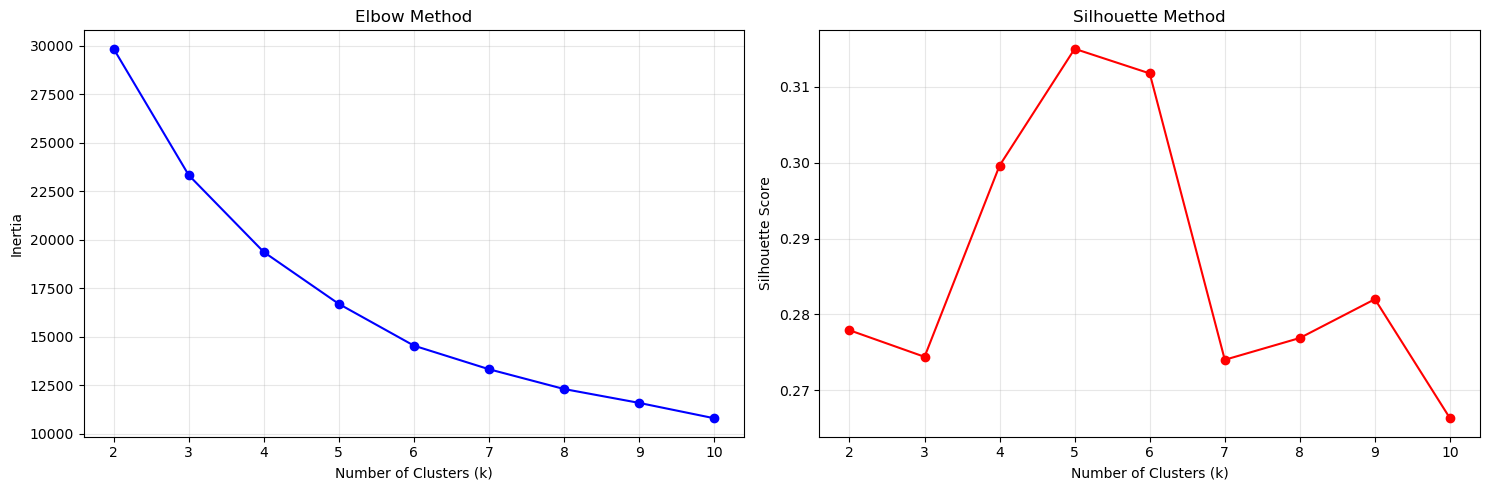

In [20]:
def create_silhouette_elbow_scores(K_range, data):
    inertia_values = []
    silhouette_scores = []  
    
    # For faster computation if dataset is large
    max_samples = min(10000, data.shape[0]) 
    indices = np.random.choice(data.shape[0], max_samples, replace=False)
    data_sample = data[indices]
    
    for k in K_range:
        # Fit KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(data_sample)
    
        # Compute metrics
        inertia_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data_sample, clusters))
    
        print(f"K={k}, Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

    return inertia_values, silhouette_scores

def plot_silhouette_elbow_scores(intertia_values, silhouette_scores):
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow method plot
    ax1.plot(K_range, inertia_values, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette score plot
    ax2.plot(K_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Method')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

K_range = range(2,11)
inertia_values, silhouette_scores = create_silhouette_elbow_scores(K_range, x)
plot_silhouette_elbow_scores(inertia_values, silhouette_scores)

Using the elbow method and sillhouette scroes, we determine that the optimal number of clusters is 5. 

## 2.2 Clustering Visualization and Analysis


Data distribution across clusters:
Cluster 0: 126739 samples (13.8%)
Cluster 1: 93293 samples (10.2%)
Cluster 2: 150349 samples (16.4%)
Cluster 3: 415339 samples (45.3%)
Cluster 4: 132138 samples (14.4%)


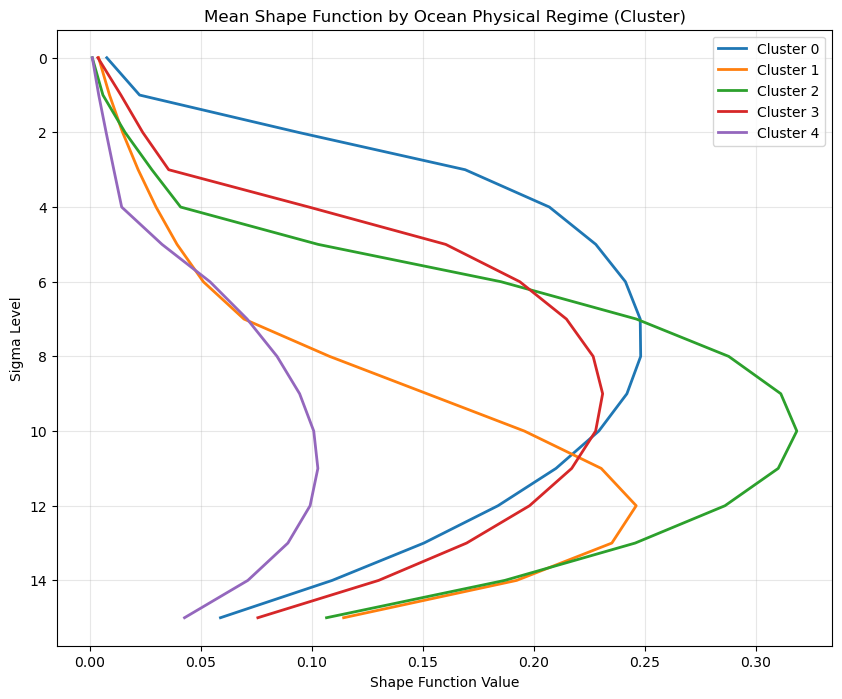

In [21]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(data)

def plot_clustered_mean_shape_functions(cluster_labels, data, Y_raw, title):
    # Check the distribution of data points across clusters
    cluster_counts = np.bincount(cluster_labels)
    print("\nData distribution across clusters:")
    for i in range(num_clusters):
        print(f"Cluster {i}: {cluster_counts[i]} samples ({cluster_counts[i]/len(cluster_labels)*100:.1f}%)")
        
    # Calculate the mean shape function (diffusivity profile) for each cluster
    cluster_mean_shapes = []
    for i in range(num_clusters):
        # Get indices of samples in this cluster
        indices = np.where(cluster_labels == i)[0]
        
        # Calculate mean shape function for this cluster
        mean_shape = np.mean(Y_raw[indices], axis=0)
        cluster_mean_shapes.append(mean_shape)

    # Plot the mean shape functions by cluster
    plt.figure(figsize=(10, 8))
    sigma_levels = np.arange(16)  # 16 vertical levels
    
    for i in range(num_clusters):
        plt.plot(cluster_mean_shapes[i], sigma_levels, label=f'Cluster {i}', linewidth=2)
        
    plt.ylabel('Sigma Level')
    plt.xlabel('Shape Function Value')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.gca().invert_yaxis()  # Invert Y-axis for ocean depth convention
    plt.show()

Y_raw = data_load_main[:,4:20]
title = 'Mean Shape Function by Ocean Physical Regime (Cluster)'
plot_clustered_mean_shape_functions(cluster_labels, x, Y_raw, title)

Furthermore, we visualize the distribution of physical parameters in each cluster using butterfly charts:

         coriolis                          buoyancy_flux                \
             mean       std  min       max          mean           std   
cluster                                                                  
0        0.000102  0.000041  0.0  0.000145  9.343289e-08  6.962423e-08   
1        0.000009  0.000018  0.0  0.000145 -3.377226e-08  7.445851e-08   
2        0.000047  0.000028  0.0  0.000145  3.498209e-09  4.511769e-08   
3        0.000114  0.000030  0.0  0.000145  7.550954e-09  3.361929e-08   
4        0.000108  0.000035  0.0  0.000145 -9.851355e-08  6.759975e-08   

                                    friction_vel                      \
                  min           max         mean       std       min   
cluster                                                                
0        3.500991e-09  2.100595e-07     0.012975  0.010085  0.000000   
1       -2.100595e-07  2.100595e-07     0.020472  0.006782  0.009868   
2       -2.100595e-07  2.100595e-07     0.02440

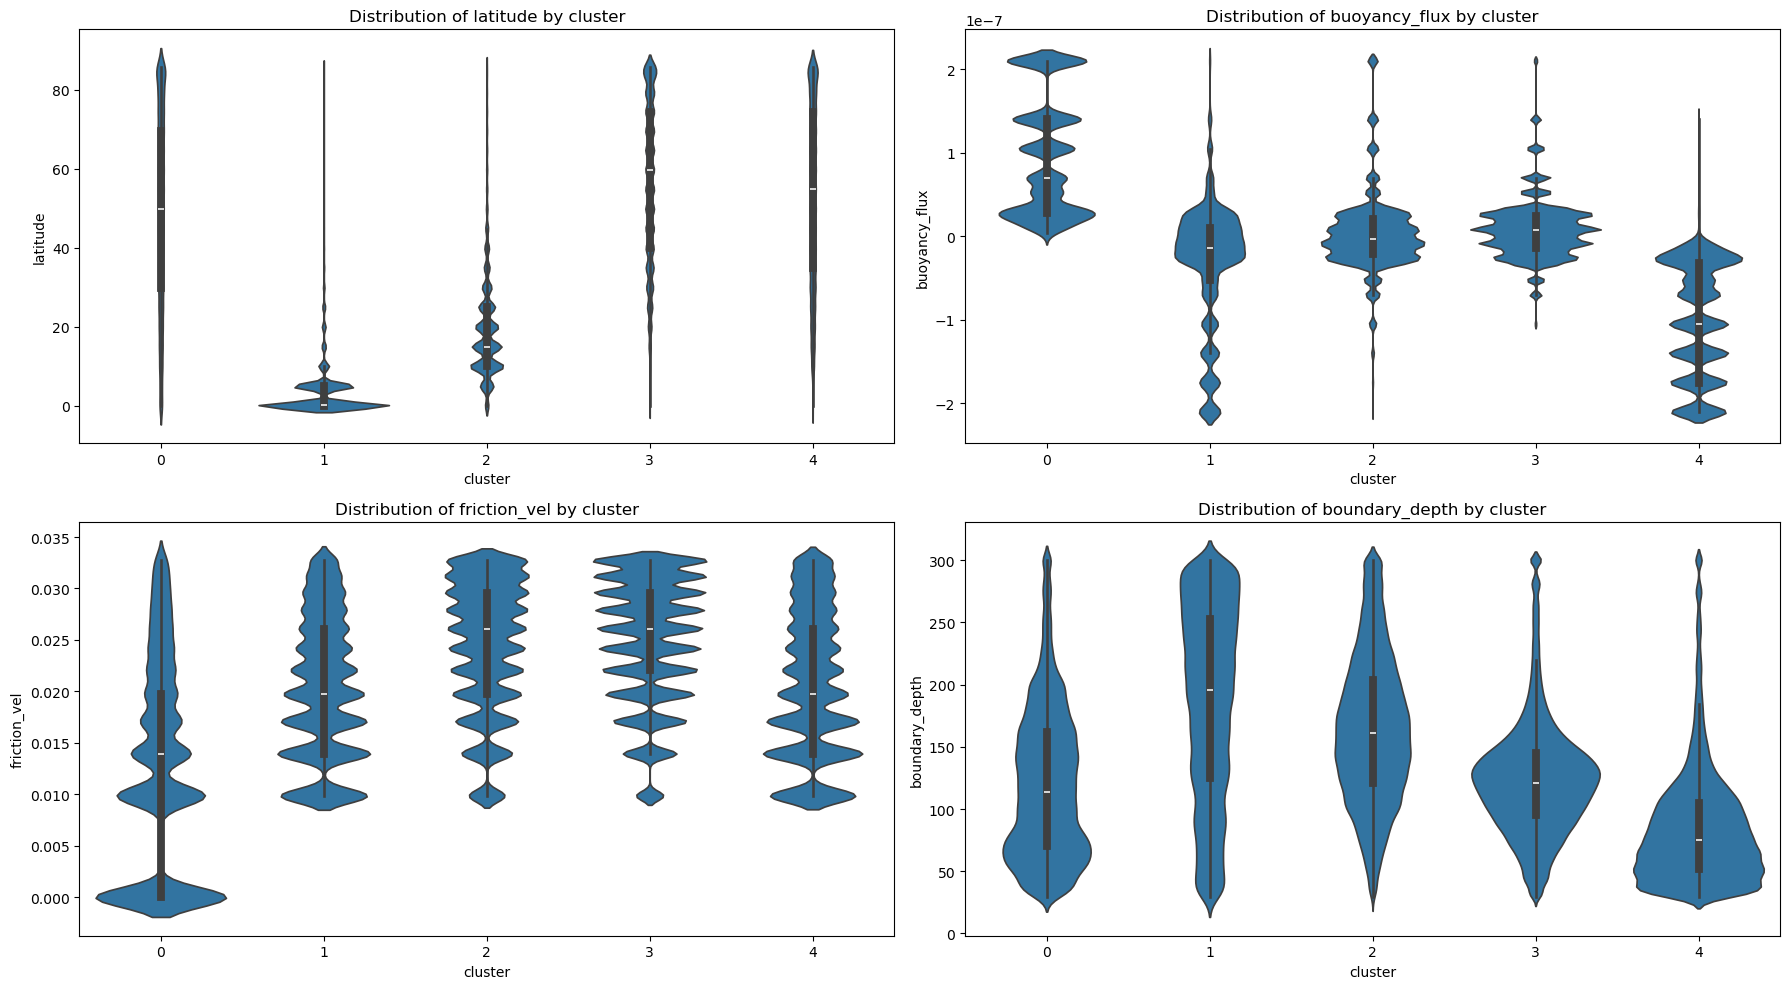

In [22]:
def coriolis_to_latitude(f):
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    sin_lat = f/(2*omega)
    # Handling edge cases to prevent numerical errors
    sin_lat = np.clip(sin_lat, -1.0, 1.0)
    return np.degrees(np.arcsin(sin_lat))

def plot_cluster_distributions_by_physical_parameters(cluster_labels, X_raw):
    # Create a dataframe with physical variables and cluster labels
    df_analysis = pd.DataFrame(X_raw, columns=['coriolis', 'buoyancy_flux', 'friction_vel', 'boundary_depth'])
    df_analysis['cluster'] = cluster_labels

    df_analysis['latitude'] = coriolis_to_latitude(df_analysis['coriolis'])
    
    # Descriptive statistics by cluster
    cluster_stats = df_analysis.groupby('cluster').agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)
    
    # Visualization of distributions
    fig, axes = plt.subplots(2, 2, figsize=(18, 10)) 
    axes = axes.flatten()
    
    variables = ['latitude', 'buoyancy_flux', 'friction_vel', 'boundary_depth']
    for i, column in enumerate(variables):
        #sns.boxplot(x='cluster', y=column, data=df_analysis, ax=axes[i])
        sns.violinplot(x='cluster', y=column, data=df_analysis, ax=axes[i])
        axes[i].set_title(f'Distribution of {column} by cluster')
    
    # Remove the empty subplot
    if len(axes) > len(variables):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()

X_raw = data_load_main[:,:4]
plot_cluster_distributions_by_physical_parameters(cluster_labels, X_raw)   

We provide some analysis on the physical interpretation of these clusters below:

| Cluster | Vertical Structure | Physical Variables | Turbulence vs Stability |
|---------|--------------------|--------------------|--------------------------|
| **0** | Uniform full-depth mixing – high mixing throughout the column. | Strong combined forcing (e.g. intense winds and/or bottom currents); very weak stratification. | Turbulence-dominated (mixing overwhelms stability at all depths). |
| **1** | Surface-intensified mixing – mixing strong at surface, dies off with depth. | Strong surface forcing (wind-driven or convective); relatively stable deep water (weaker bottom forcing). | Surface turbulence dominates (stable stratification below). |
| **2** | Bottom-intensified mixing – mixing peak near seabed. | Strong bottom forcing (tidal flow, bottom stress); calmer surface conditions (stable upper water column). | Bottom turbulence dominates (stable upper layer). |
| **3** | Two-layer (double-peak) mixing – high mixing at surface & bottom, lower in the middle. | Moderate forcing at both surface and bottom; stratified mid-depth that limits interior mixing. | Mixed regime: turbulence at boundaries, stability in mid-depth. |
| **4** | Weak mixing, stratification-limited – very low mixing overall. | Very weak forcing; strong stratification (high stability suppressing turbulence). | Stability-dominated (turbulence minimal; mixing heavily suppressed). |


## 2.3 SOM Clustering by Physical Regime

A Self Organizing Map aims to reduce the number of features in a data set while maintaining the same overall topology/shape of the data. Our hope with this was to identify any patterns in the physical parameters that corresponded to spatial and physical patterns such as season or geographic region. 


In [37]:
def custom_som_clustering(X, grid_size=(10, 10), n_iterations=200):
   n_neurons = grid_size[0] * grid_size[1]
   n_features = X.shape[1]
   
   np.random.seed(42)
   neuron_weights = X[np.random.choice(X.shape[0], n_neurons, replace=False)]
   neuron_weights = neuron_weights.reshape(grid_size[0], grid_size[1], -1)
   
   learning_rate = 0.1
   sigma = max(grid_size) / 2
   
   for iteration in range(n_iterations):
       current_lr = learning_rate * (1 - iteration / n_iterations)
       current_sigma = sigma * (1 - iteration / n_iterations)
       
       sample = X[np.random.randint(X.shape[0])]
       
       distances = np.sum((neuron_weights - sample)**2, axis=2)
       winner_idx = np.unravel_index(np.argmin(distances), grid_size)
       
       for i in range(grid_size[0]):
           for j in range(grid_size[1]):
               neuron_dist = np.sqrt(((i-winner_idx[0])**2 + (j-winner_idx[1])**2))
               
               if neuron_dist <= current_sigma:
                   influence = np.exp(-(neuron_dist**2) / (2*(current_sigma**2)))
                   neuron_weights[i, j] += current_lr * influence * (sample - neuron_weights[i, j])
   
   neuron_assignments = np.zeros((X.shape[0],), dtype=int)
   for idx, sample in enumerate(X):
       distances = np.sum((neuron_weights.reshape(-1, n_features) - sample)**2, axis=1)
       neuron_assignments[idx] = np.argmin(distances)
   
   return neuron_weights, neuron_assignments

Plotting mean shape function of SOM Clusters

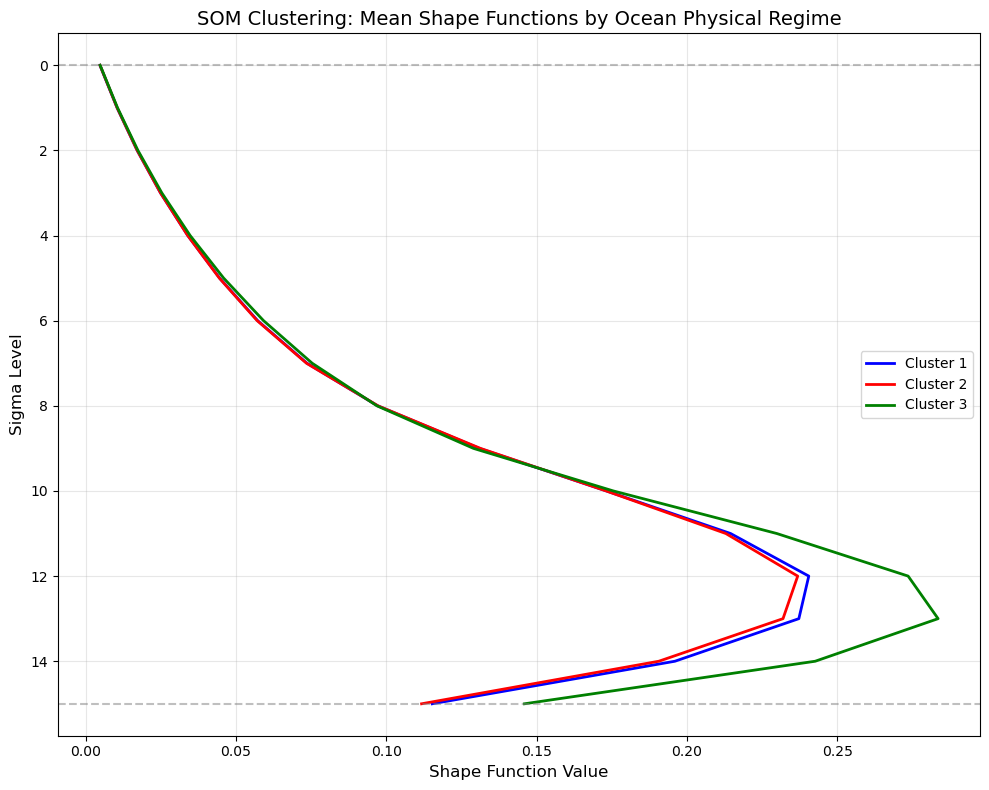

In [38]:

def plot_som_clustered_shape_functions(clusters, Y_raw, k=3):
    unique_clusters = np.unique(clusters)

    cluster_mean_shapes = []
    for i in unique_clusters:
        indices = np.where(clusters == i)[0]
        
        if len(indices) > 0:
            mean_shape = np.mean(Y_raw[indices], axis=0)
            cluster_mean_shapes.append(mean_shape)
        else:
            print(f"Warning: Cluster {i} has no samples")
            cluster_mean_shapes.append(np.zeros(Y_raw.shape[1]))
    
    plt.figure(figsize=(10, 8))
    sigma_levels = np.arange(16)
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
    linestyles = ['-', '--', '-.', ':']
    for idx, i in enumerate(unique_clusters):
        color_idx = idx % len(colors)
        style_idx = idx // len(colors) % len(linestyles)
        
        plt.plot(
            cluster_mean_shapes[idx], 
            sigma_levels, 
            label=f'Cluster {i}',
            color=colors[color_idx],
            linestyle=linestyles[style_idx],
            linewidth=2
        )
    
    plt.ylabel('Sigma Level', fontsize=12)
    plt.xlabel('Shape Function Value', fontsize=12)
    plt.title('SOM Clustering: Mean Shape Functions by Ocean Physical Regime', fontsize=14)
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.gca().invert_yaxis()
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(y=15, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return cluster_mean_shapes


neuron_weights, neuron_assignments = custom_som_clustering(x)
flat_weights = neuron_weights.reshape(-1,x.shape[1])

distance_matrix = pdist(flat_weights, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')
k = 3
clusters = fcluster(linkage_matrix, k, criterion='maxclust')
clusters = clusters.reshape(10, 10)    

cluster_mean_shapes = plot_som_clustered_shape_functions(clusters.flatten(), Y_raw)


Unfortunately, we do not notice singificant variance among the mean shape function of the SOM clusters. 

The K-means clusters ar certainly meaningful and useful. However, it will take too much compute time for the scope of this project to train a neural network for each cluster. A such, we will try clustering by the shape function to see if we can get a useful reduction. 

# 3 Clustering by Shape Function with K-means

## 3.1 Determning optimal number of clusters

K=2, Inertia=95154.73, Silhouette=0.4545
K=3, Inertia=63723.77, Silhouette=0.4165
K=4, Inertia=44687.91, Silhouette=0.4144
K=5, Inertia=36544.54, Silhouette=0.3708
K=6, Inertia=31839.37, Silhouette=0.4022
K=7, Inertia=27509.35, Silhouette=0.3928
K=8, Inertia=24415.61, Silhouette=0.3448
K=9, Inertia=21490.22, Silhouette=0.3590
K=10, Inertia=19083.02, Silhouette=0.3621


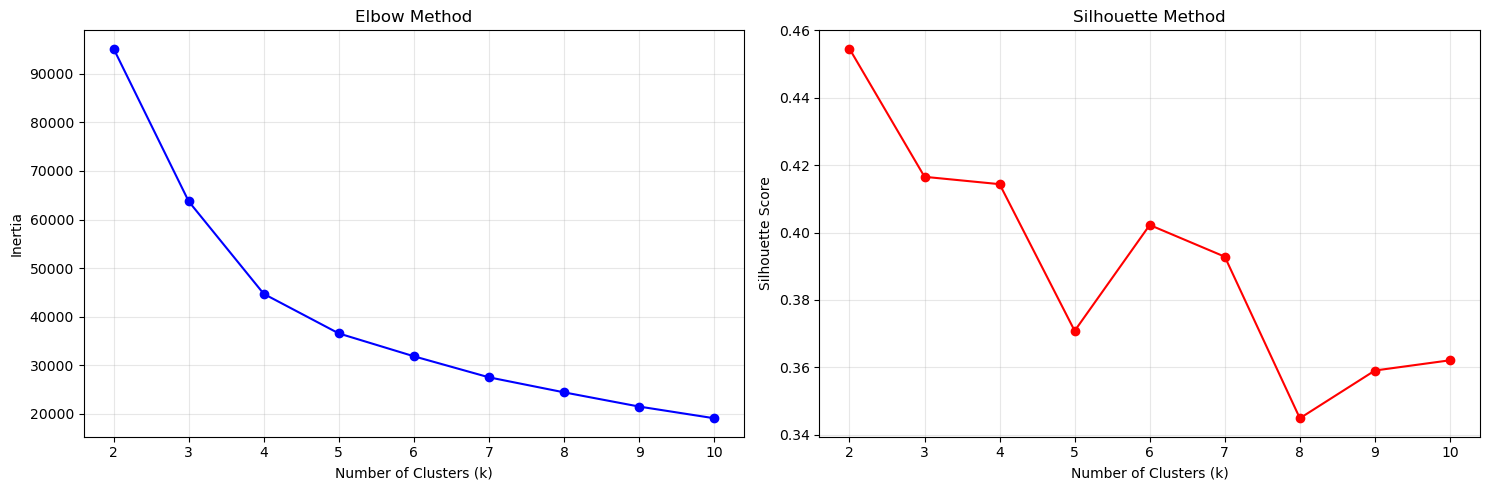

In [41]:
inertia_values, silhouette_scores = create_silhouette_elbow_scores(K_range, y)
plot_silhouette_elbow_scores(inertia_values, silhouette_scores)

Based on the elbow method and silhouette scores, we determine that the optimal number of clusters is 4. As such, we analyze the k-means shape function based clustering using 4 clusters.

## 3.2 Visualization and Analysis of Shape Function based clusters


Data distribution across clusters:
Cluster 0: 126739 samples (13.8%)
Cluster 1: 93293 samples (10.2%)
Cluster 2: 150349 samples (16.4%)
Cluster 3: 415339 samples (45.3%)


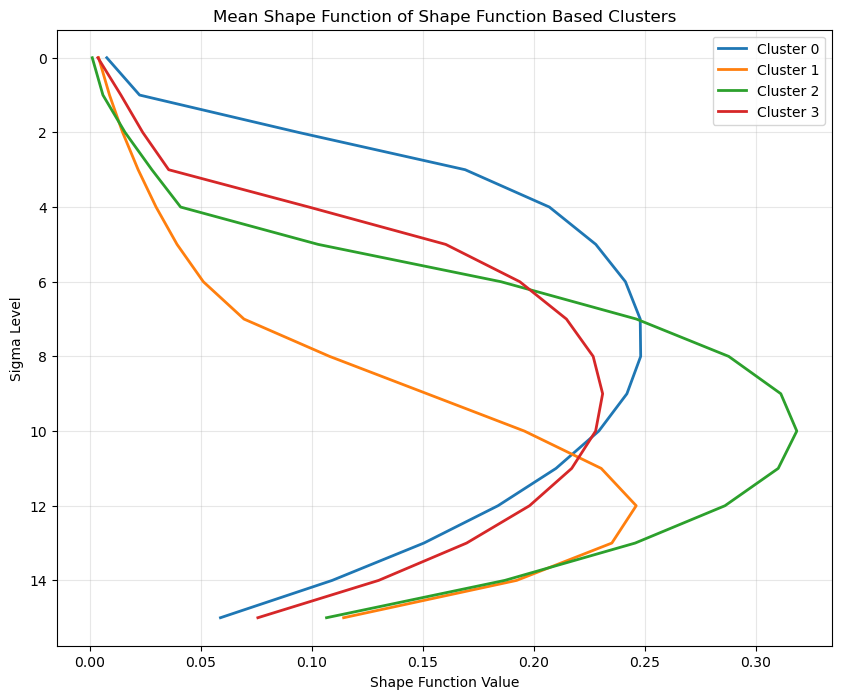

         coriolis                          buoyancy_flux                \
             mean       std  min       max          mean           std   
cluster                                                                  
0        0.000103  0.000041  0.0  0.000145  9.238468e-08  6.913334e-08   
1        0.000073  0.000044  0.0  0.000145 -5.340752e-08  7.732280e-08   
2        0.000111  0.000033  0.0  0.000145  5.892896e-09  3.589387e-08   
3        0.000010  0.000019  0.0  0.000145 -3.496288e-08  7.521322e-08   

                                    friction_vel                      \
                  min           max         mean       std       min   
cluster                                                                
0        3.500991e-09  2.100595e-07     0.013277  0.010120  0.000000   
1       -2.100595e-07  2.100595e-07     0.022485  0.006926  0.009868   
2       -1.750496e-07  2.100595e-07     0.024994  0.006054  0.009868   
3       -2.100595e-07  2.100595e-07     0.020432 

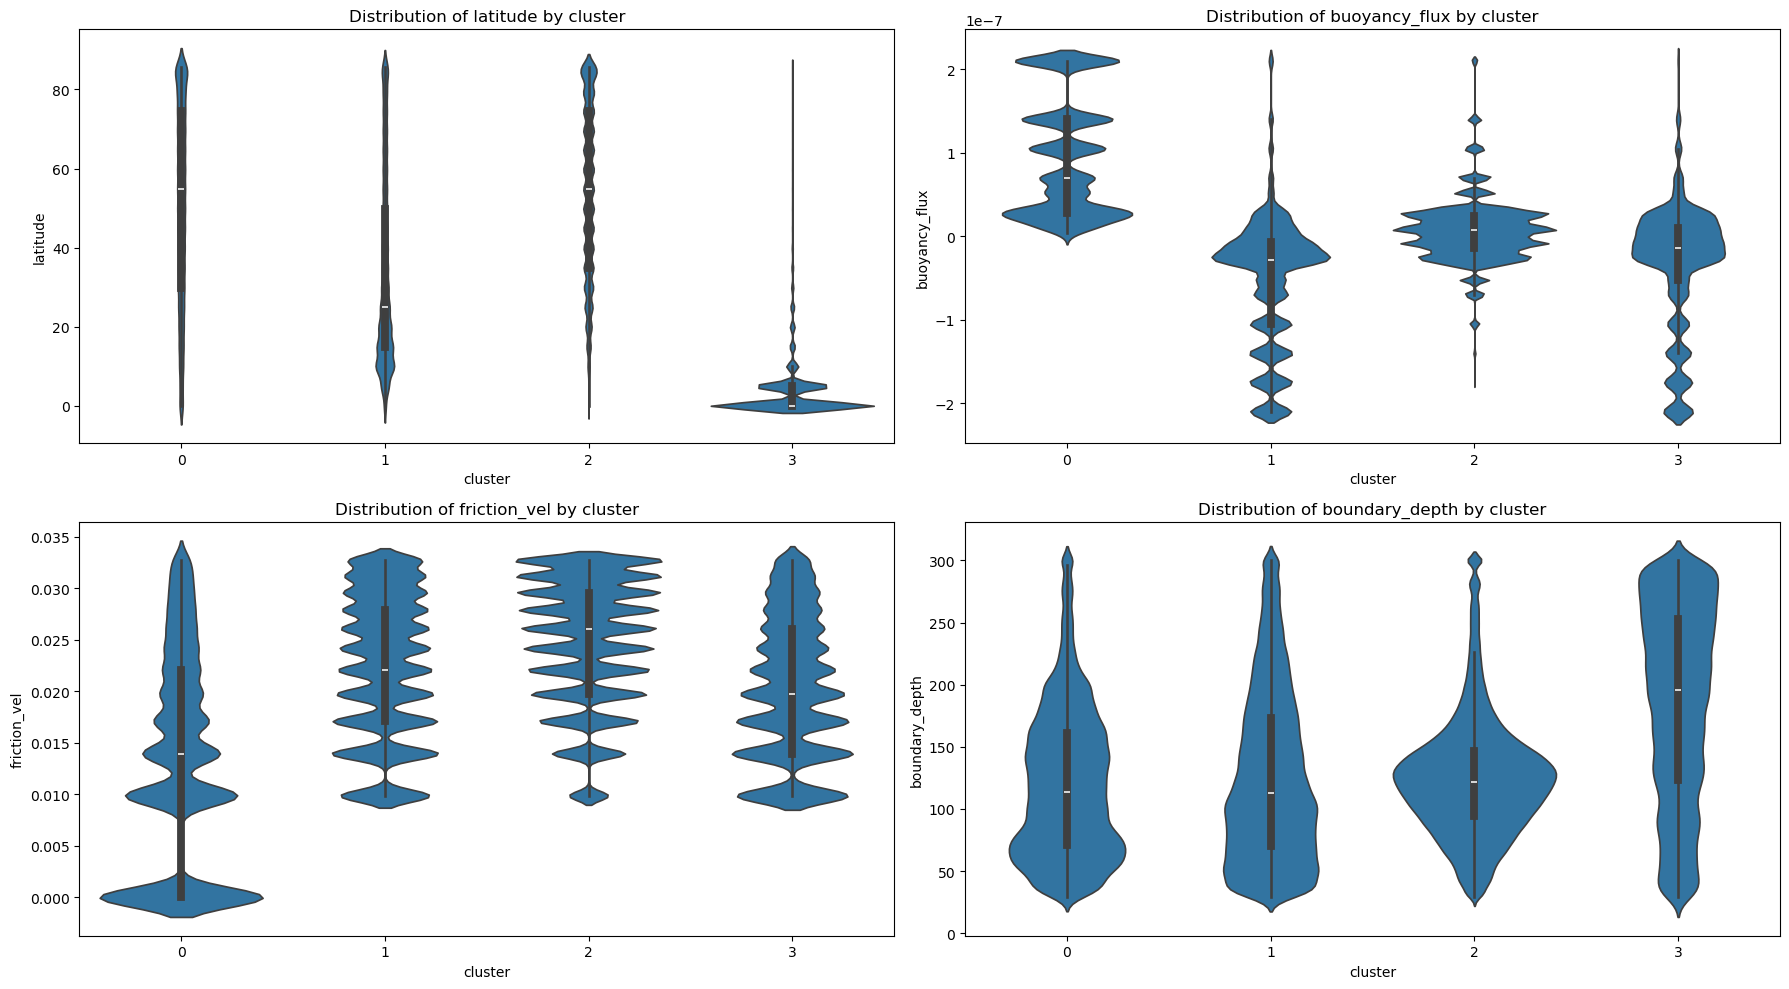

In [42]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels2 = kmeans.fit_predict(data)

title = 'Mean Shape Function of Shape Function Based Clusters'
plot_clustered_mean_shape_functions(cluster_labels, y, Y_raw, title)
plot_cluster_distributions_by_physical_parameters(cluster_labels2, X_raw)



Remarkably, the shape function based clustering produces sets of parameters that are very similar to the physical regime based clustering, highlighting the consistency of our clustering method. We provide an analysis below:

| Cluster | Vertical Structure (Profile Shape) | Typical Forcing Scenario | Turbulence vs Stability |
|---------|-----------------------------------|--------------------------|-------------------------|
| 0       | Bottom-intensified profile       | Tidal currents, bottom stress | Turbulence near seabed |
| 1       | Surface-intensified profile      | Wind-driven surface mixing | Turbulence near surface |
| 2       | Double-peak profile              | Combined surface & bottom forcing or strong stratification | Mixed: turbulent at boundaries, stable in mid-depth |
| 3       | Uniform profile                  | Convective mixing, multiple forcing sources | Strong turbulence, deep mixing |


Given that  the physical regime offers more detail and variation across the mean shape functions of each cluster, we chose to improve upon that clustered dataset further. 

Given our computational limitations for this project, intead of training a neural network on each cluser, we thought it would be of interest to train a neural network to take in a shape function and predict the possible set of paramaters that could produce it. That is, we train a neural network to classify the shape function by which clustr the parameters that could of produced the shape function belonged to. 

# 4 Cluster Prediction NN

## 4.1 Split and process data

In [43]:
train_idx = int(np.floor(0.4*data_load_main.shape[0]))

output_train = cluster_labels[:train_idx]
output_valid = cluster_labels[train_idx:2*train_idx]
output_test = cluster_labels[2*train_idx:]

output_train = torch.LongTensor(output_train).to(device)
output_valid = torch.LongTensor(output_valid).to(device)
output_test = torch.LongTensor(output_test).to(device)

input_train = Y_raw[:train_idx]
input_valid = Y_raw[train_idx:2*train_idx]
input_test = Y_raw[2*train_idx:]

input_train = torch.FloatTensor(input_train).to(device)
input_valid = torch.FloatTensor(input_valid).to(device)
input_test = torch.FloatTensor(input_test).to(device)

## 4.2 Define NN Architecture

In [44]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes=16, Hid=32, Out_nodes=5):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout
        
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred

## 4.3 Train NN

In [45]:
def modeltrain_loss(epochs, x, y, valid_x, valid_y, model, loss_fn, optim, patience=100):
    loss_array = torch.zeros([epochs, 3])
    best_loss = float('inf')
    no_improvement = 0
    best_model_state = None

    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()
            y_pred = model(x)
            valid_pred = model(valid_x)
           
            loss = loss_fn(y_pred, y)
            loss_valid =  loss_fn(valid_pred , valid_y )
            loss.backward()
            optimizer.step()

            loss_array[k, 0] = k  
            loss_array[k, 1] = loss.item()  
            loss_array[k, 2] = loss_valid.item()

            pbar.set_postfix(train_loss=loss.item(), valid_loss=loss_valid.item(), patience_count=no_improvement)
            pbar.update(1)

            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()
                no_improvement = 0
                best_model_state = model.state_dict()  
            else:
                no_improvement += 1

            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            del loss, y_pred

    # Restore best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model , loss_array[:k, :]

In [46]:
epochs, lr =3000, 1e-03

model = learnKappa_layers()
model = model.to(device)

negative_log_loss = nn.NLLLoss()
log_softmax = nn.LogSoftmax(dim=1)
def loss_fn(pred, target): return negative_log_loss(log_softmax(pred), target)
 
optimizer = optim.Adam(model.parameters(), lr)

model, loss_array = modeltrain_loss(epochs, input_train, output_train, input_valid, output_valid, model, loss_fn, optimizer)

Training Progress: 100%|██████████| 3000/3000 [01:47<00:00, 28.02epoch/s, patience_count=0, train_loss=0.179, valid_loss=0.266] 


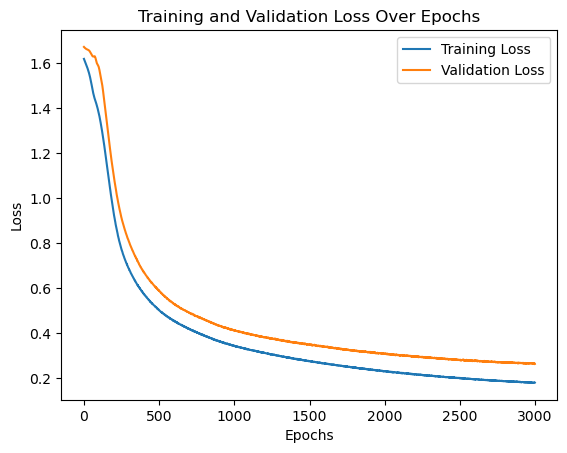

In [47]:
def plot_loss(loss_array):
    plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss")
    plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss")
    
    # Adding labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    
    # Adding a legend
    plt.legend()
    
    # Displaying the plot
    plt.show()

plot_loss(loss_array)

## 4.4 Evaluate performance of cluster prediciton NN

Test Accuracy: 90.75%


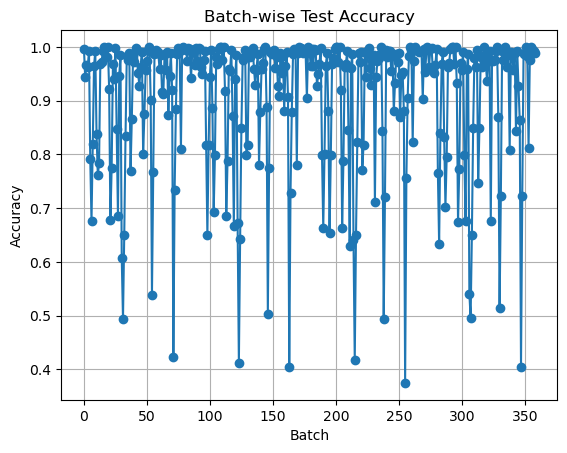

In [48]:
def evaluate_nn(model, input_test, output_test, batch_size):
    #switch model to proper device and put in eval mode
    device = next(model.parameters()).device
    model.eval()

    # create data loader fro test data
    test_dataset = TensorDataset(input_test, output_test)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    total = 0
    correct = 0
    batch_accuracies = []
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
    
            outputs = model(x_batch)                          # shape: [B, num_classes]
            _, predicted = torch.max(outputs, 1)              # take class with highest score
    
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
            batch_acc = (predicted == y_batch).float().mean().item()
            batch_accuracies.append(batch_acc)
    
    
    overall_accuracy = 100 * correct / total
    print(f'Test Accuracy: {overall_accuracy:.2f}%')
    return batch_accuracies, overall_accuracy

def plot_batch_accuracies(batch_accuracies):
    plt.plot(batch_accuracies, marker='o')
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.title("Batch-wise Test Accuracy")
    plt.grid(True)
    plt.show()

batch_size = 512
batch_accuracies, _ = evaluate_nn(model, input_test, output_test, batch_size)
plot_batch_accuracies(batch_accuracies)


# Discussion & Conclusion


Bringing all the pieces together, we have developed a clearer picture of ocean mixing regimes through data-driven analysis. By clustering the data based on physical regimes, we identified distinct groups that correspond to intuitive mixing patterns (surface-driven, bottom-driven, uniformly turbulent, etc.). Clustering directly by the shape of the mixing profiles yielded very similar groupings, confirming that those vertical shape functions are tightly linked to the underlying physical conditions. The fact that a simple profile’s shape could essentially reveal which physical regime it came from is a central finding of this project. It highlights that the shape function encapsulates rich physical information: the distribution of mixing with depth is a signature of the processes driving it.

The comparison of the two clustering approaches – physical-parameter-based vs shape-based – is insightful. The physical regime clustering gave us categories defined by different causal factors (like “high wind vs high tide” scenarios), while the shape-function clustering gave categories defined by different outcomes (profile shapes). Largely, these turned out to be two lenses on the same set of regimes. One notable difference was that the shape-based approach merged some regimes that were distinct in terms of forcing strength (because extremely weak mixing under high stability and moderately strong dual-boundary mixing both result in a two-layer profile shape). This suggests that if we care about the magnitude of mixing, the physical context is important; but if we care only about the pattern of mixing distribution, those cases are equivalent. In practical terms, physical regime-based clustering is valuable for interpreting cause and effect – it tells us “why” a profile looks a certain way, by linking it to environmental conditions. On the other hand, shape-based clustering is directly useful for pattern recognition – for example, classifying observed profiles into a type, or comparing with theoretical profile shapes, regardless of the exact forcing details
 
 The high accuracy of the classifier implies that if we observe a mixing profile in the ocean, we can almost confidently classify it into a regime (and thus infer the likely dominant forcing) just from its shape. This could be useful for oceanographers or modelers: given a vertical profile of turbulence observations, an automatic classifier could tag it as, say, “wind-driven upper ocean mixing” vs “bottom-driven mixing”, aiding in analysis. 
